## Data Loading and Cleaning

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import gensim

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

# Define stop words
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [ ]:
true = pd.read_csv("True.csv")
false = pd.read_csv("Fake.csv")

In [ ]:
true['category'] = 1
false['category'] = 0

In [ ]:
df = pd.concat([true,false]) #Merging the 2 datasets

In [ ]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
df.isna().sum() # Checking for nan Values

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [ ]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

# EDA and Visualisations

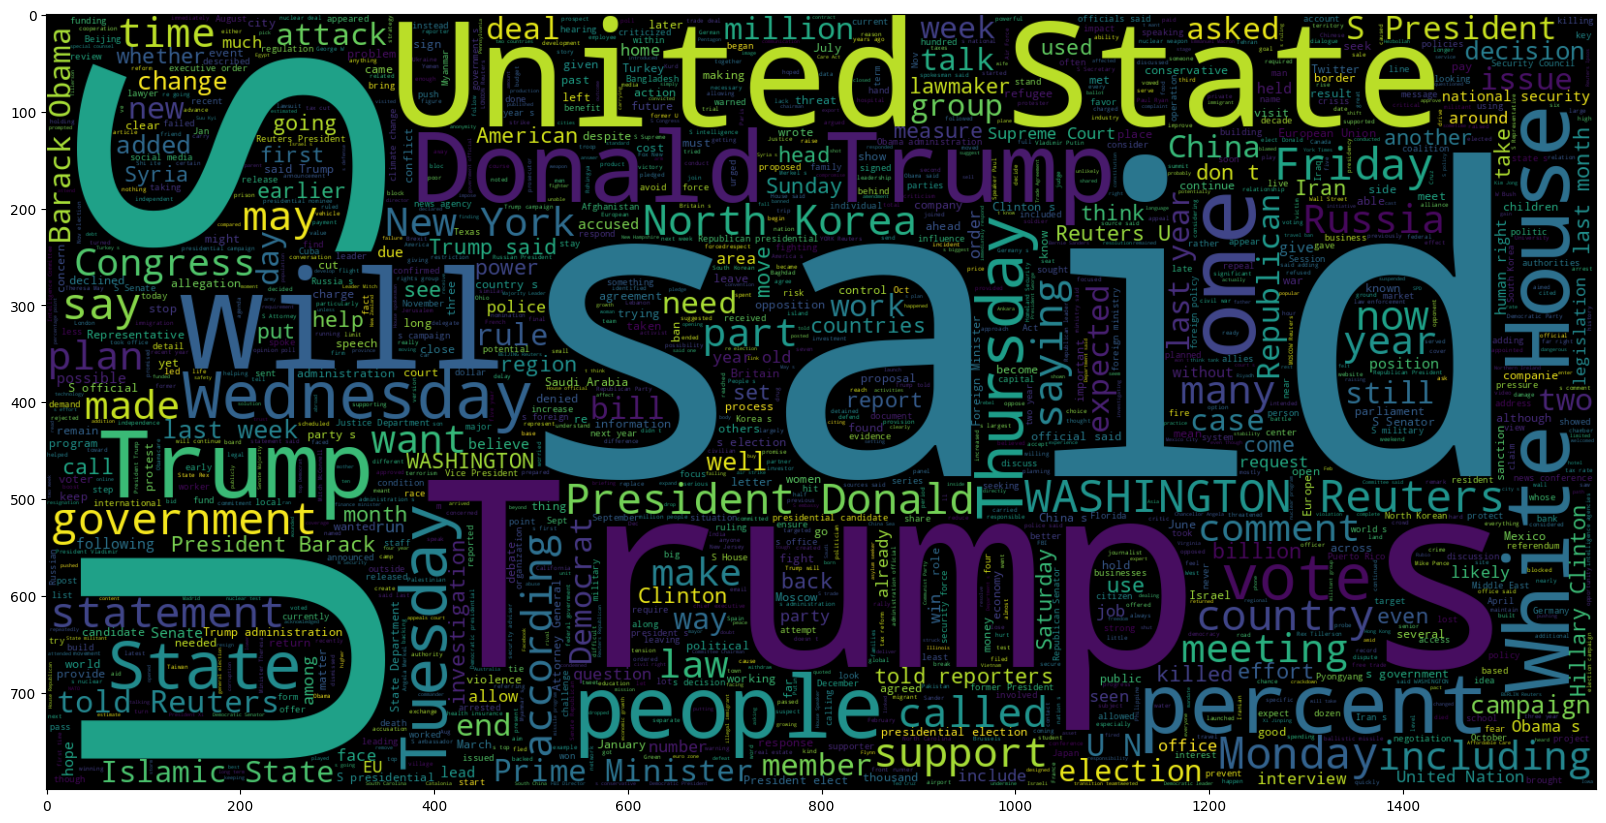

In [ ]:
## Wordcloud for True news
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

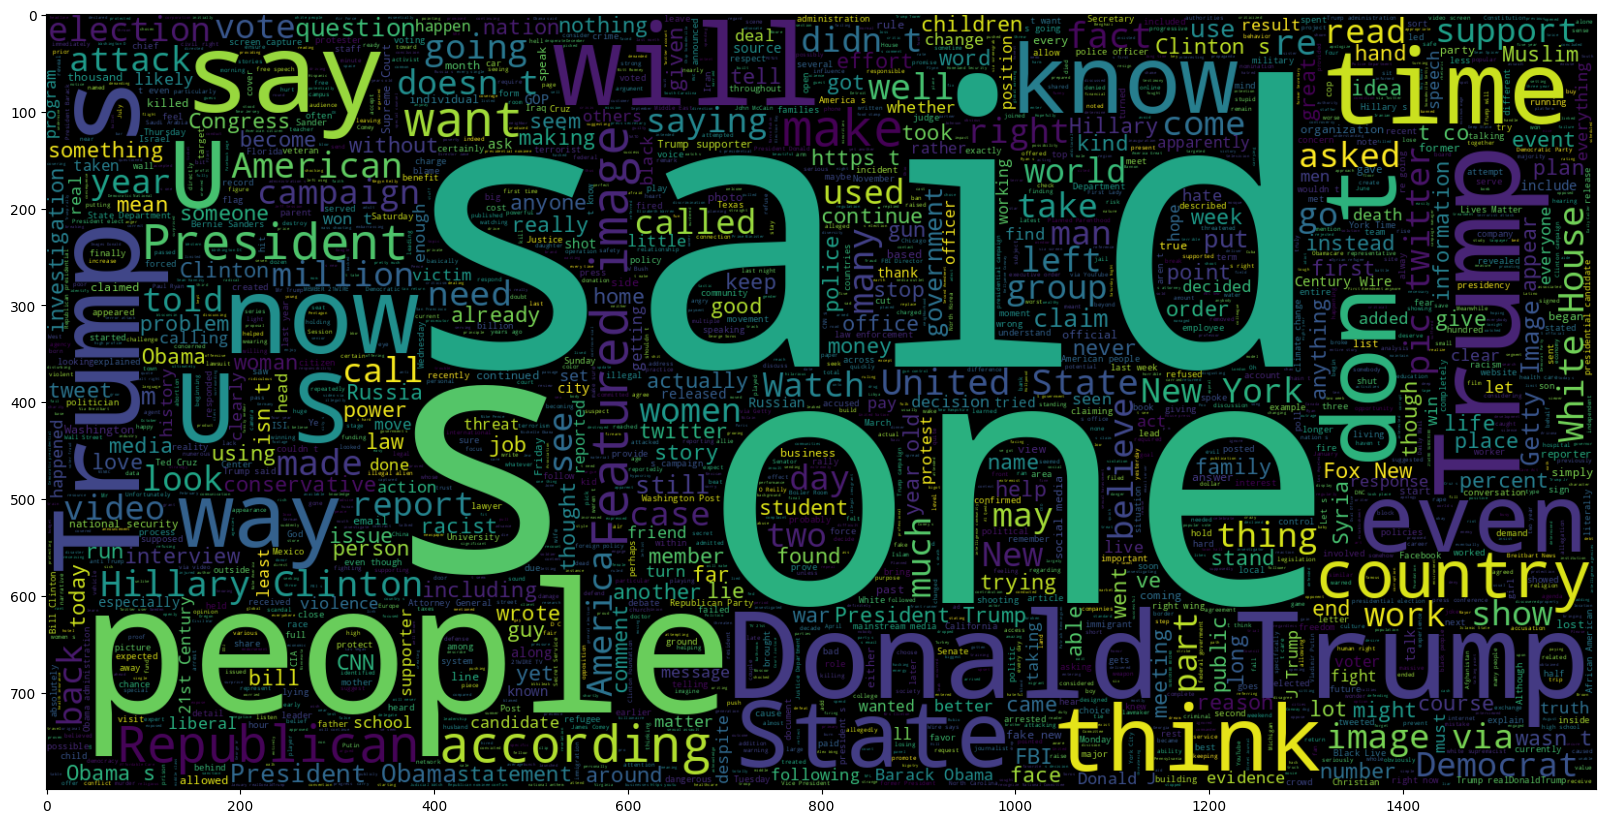

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
colors = ['gold', 'mediumturquoise']
labels = ['REAL','FAKE']
values = df['category'].value_counts()/df['category'].shape[0]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Target Balance",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
)
fig.show()

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

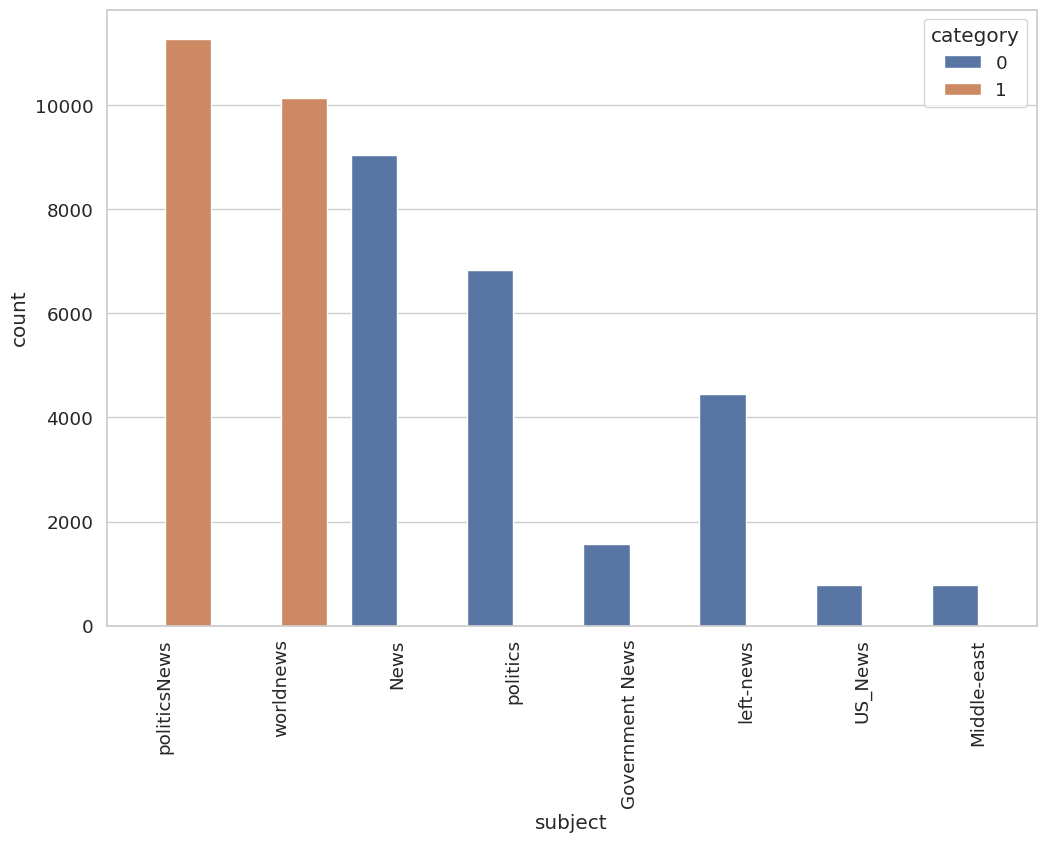

In [ ]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

In [ ]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop = set(nltk.corpus.stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

<ipython-input-14-4f1d5a4b9299>:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



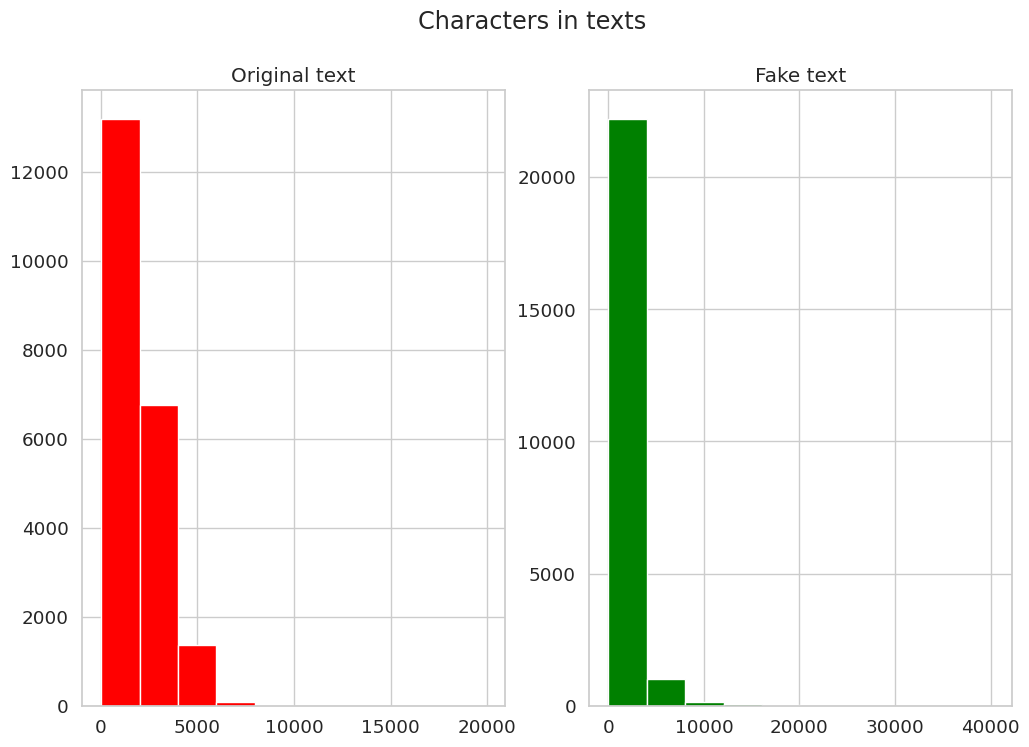

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts')
plt.show()

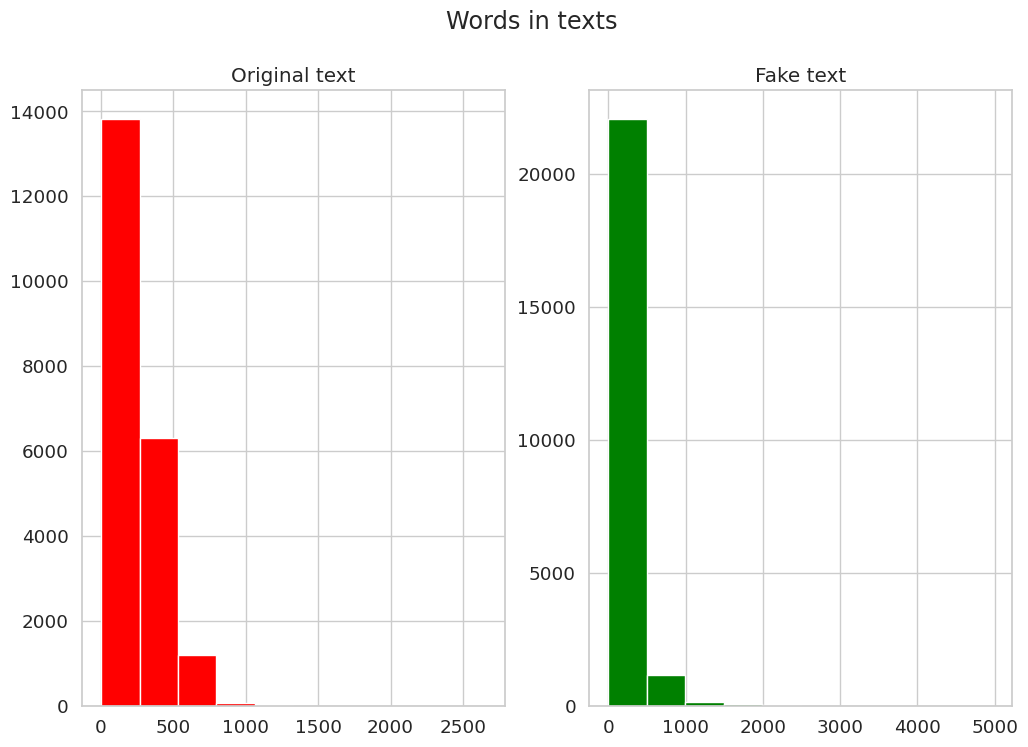

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

<ipython-input-17-cbef104b9346>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-17-cbef104b9346>:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions,

Text(0.5, 0.98, 'Average word length in each text')

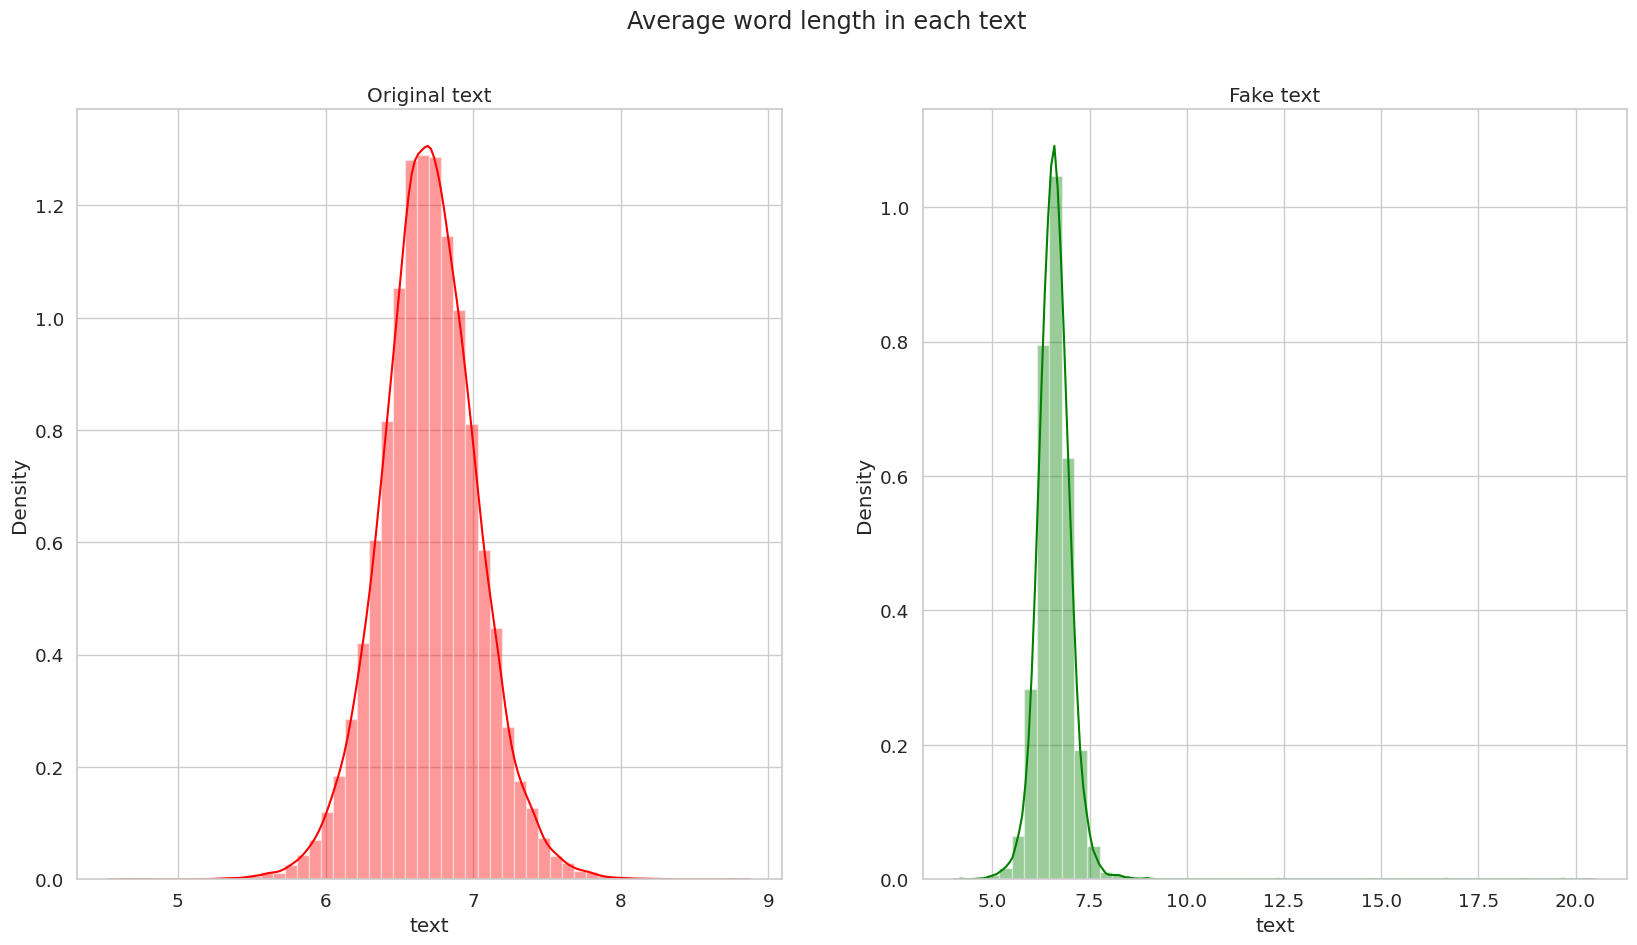

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')
word=df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Trump': 111503,
 'said': 93162,
 'would': 54613,
 'U.S.': 50441,
 'President': 33180,
 'people': 33115,
 'also': 30325,
 'one': 29370,
 'Donald': 27795,
 'said.': 26194}

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

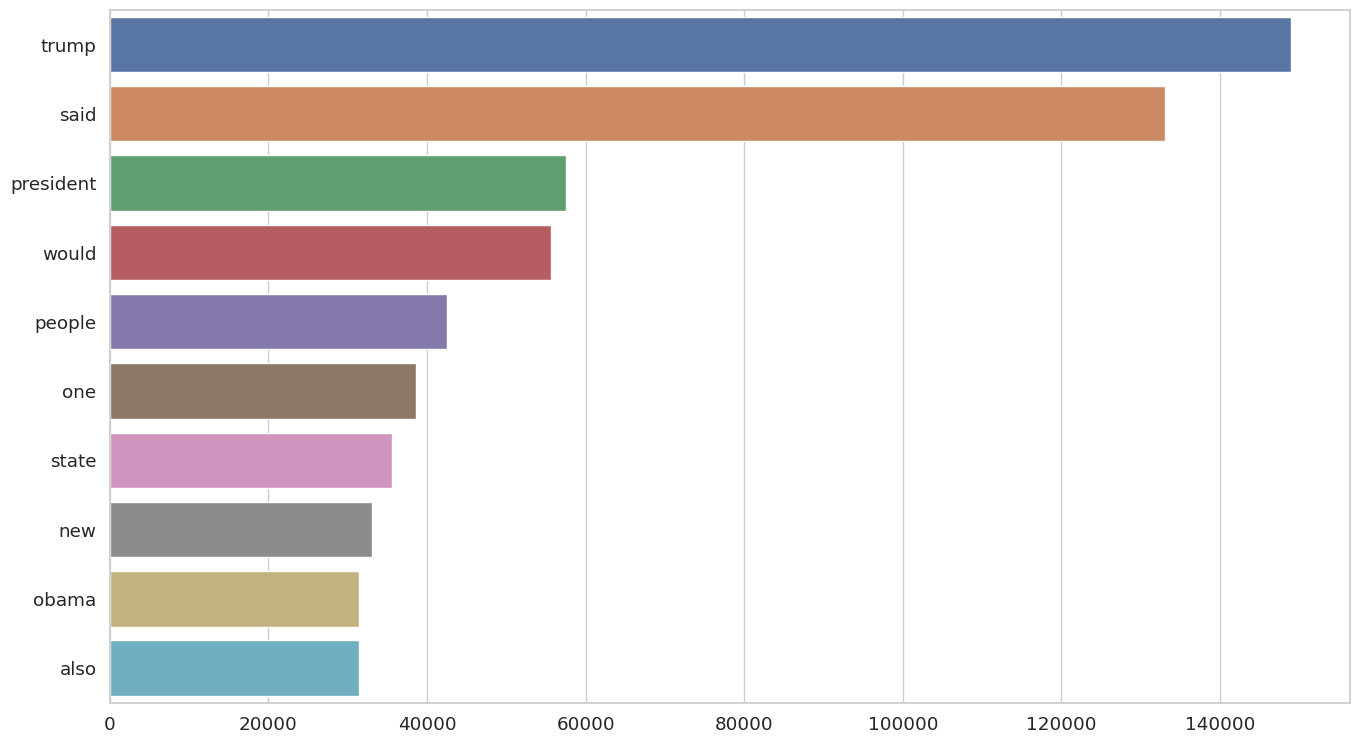

In [ ]:
## Unigram Analysis
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

<Axes: >

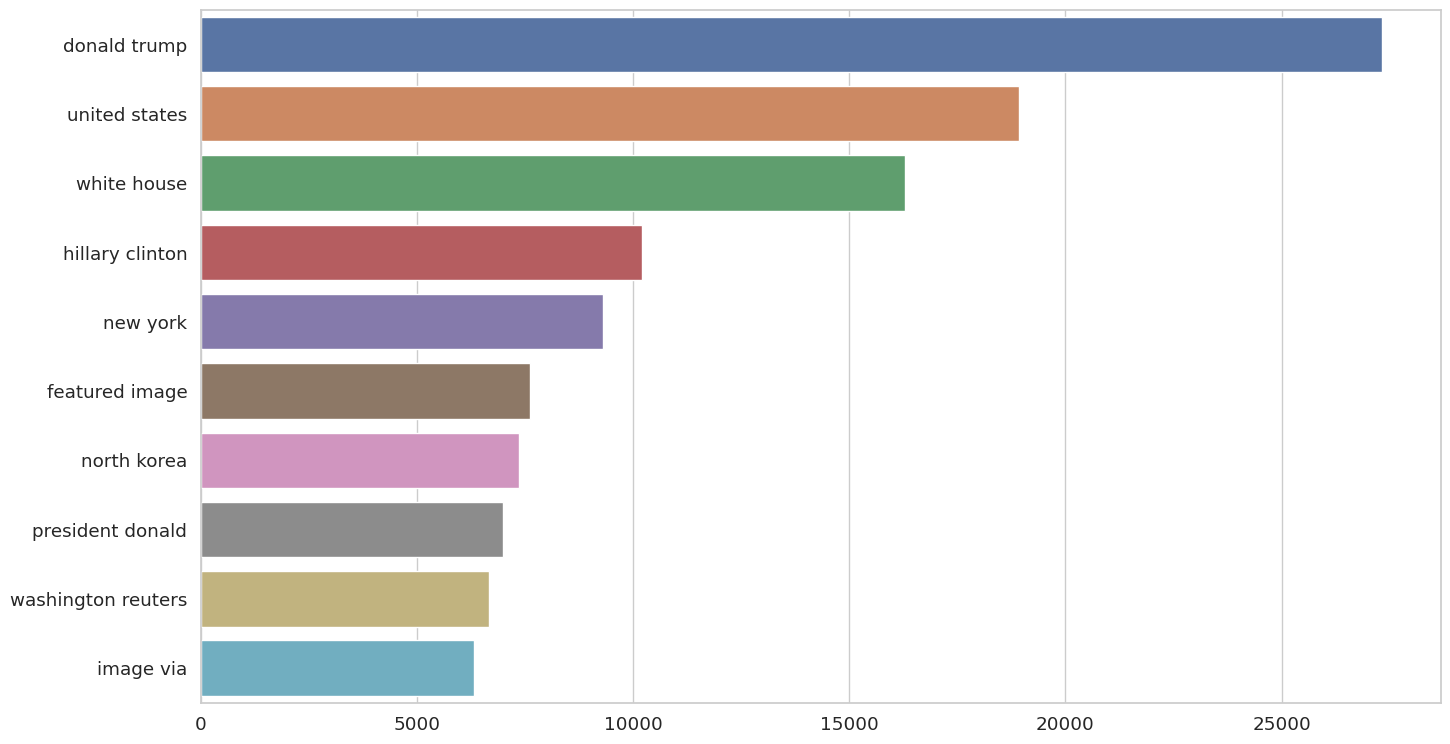

In [ ]:
## Bigram Analysis
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

<Axes: >

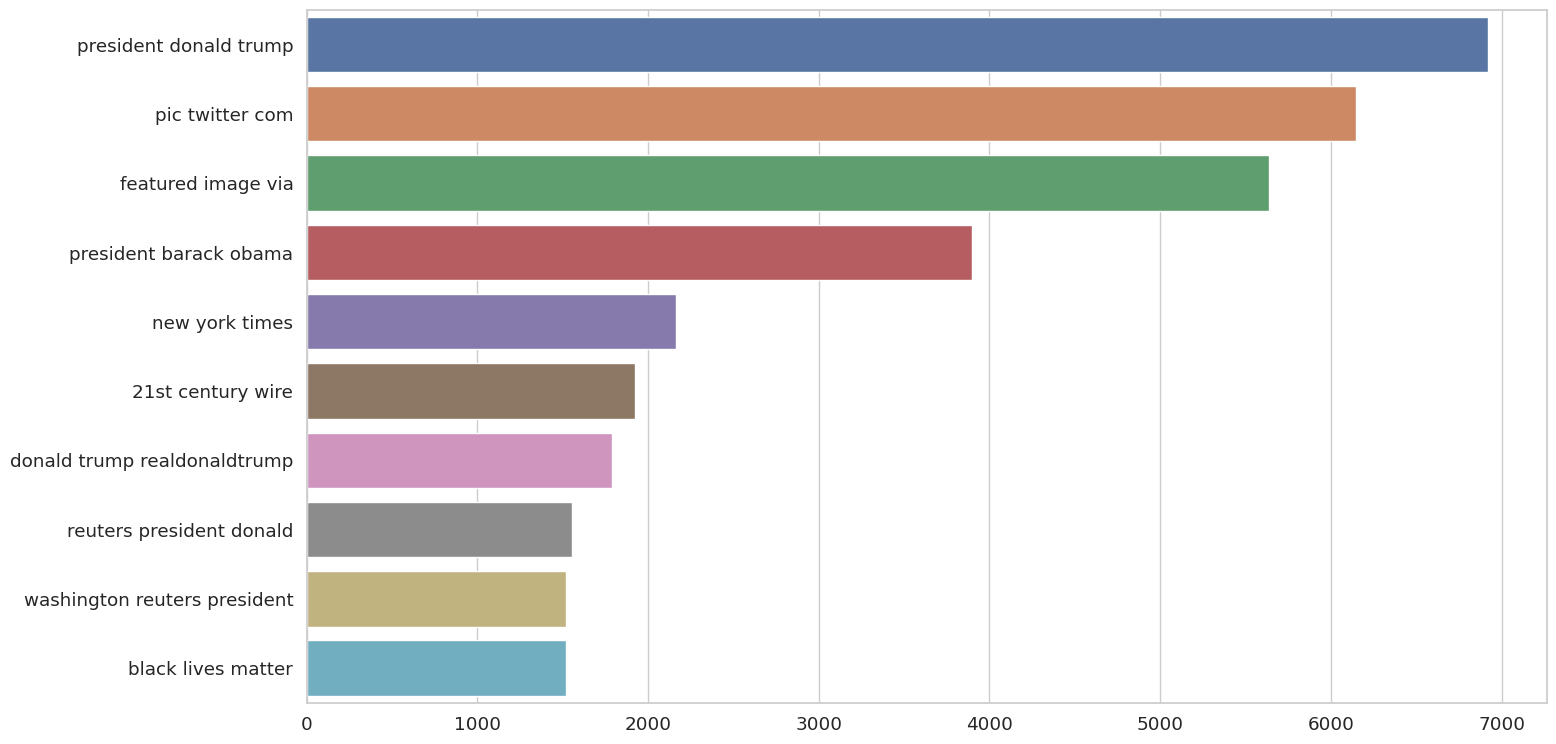

In [ ]:
## Trigram Analysis
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

## Model Training and Evaluation

In [ ]:
def train_model(X, y, algorithm, max_iter=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    name = algorithm
    # If the max_iter parameter is specified
    if max_iter:
        model = algorithm(max_iter=max_iter)
    else:
        model = algorithm()

    # create bag-of-words features
    vectorizer = CountVectorizer()
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)

    # Train the model on the original dataset
    model.fit(X_train_vect, y_train)
    
    # Predicting target variable on test data
    y_pred = model.predict(X_test_vect)
    
    
    # Evaluation Metrics on predicted values vs test values
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print('Metrics on the data: ')
    print('Accuracy: ', acc)
    print('F1 Score: ', f1 ) 
    print('Precision: ', precision) # Positive predictive value
    print('Recall: ', recall) # Sensitivity measuement metric
    print('AUC ROC Score: ', roc_auc)

    # Confusion matrix for the data
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(4, 4))
    plt.title(f"Confusion Matrix on Dataset for {type(model).__name__}")

Metrics on the data: 
Accuracy:  0.9965478841870824
F1 Score:  0.9964232144917504
Precision:  0.9956190915379295
Recall:  0.997228637413395
AUC ROC Score:  0.9965713079540093


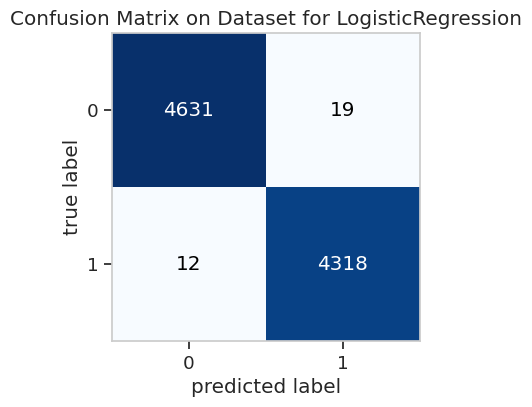

In [ ]:
train_model(df['text'], df['category'],LogisticRegression, max_iter = 500)

In [ ]:
## Naive Bayes

Metrics on the data: 
Accuracy:  0.9589086859688196
F1 Score:  0.9574247144340603
Precision:  0.9566520636384598
Recall:  0.9581986143187067
AUC ROC Score:  0.9588842533959125


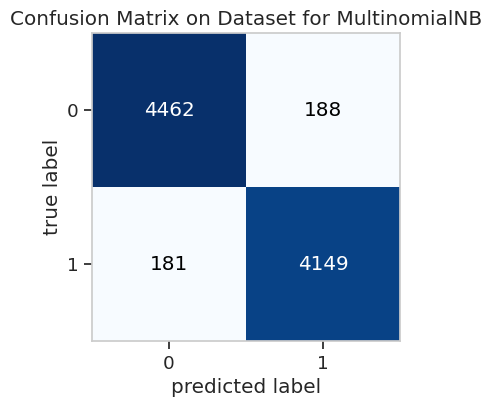

In [ ]:
train_model(df['text'], df['category'],MultinomialNB)

In [ ]:
## LSTM

In [ ]:
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

In [ ]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
len(w2v_model.wv)

118464

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])

43981

In [ ]:
maxlen = 700 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)
vocab_size = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index

In [ ]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [ ]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 700, 100)          11846500  
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 11,963,877
Trainable params: 117,377
Non-trainable params: 11,846,500
_________________________________________________________________


In [ ]:
y = df["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=3)


Epoch 1/3
737/737 [==============================] - 830s 1s/step - loss: 0.0801 - acc: 0.9711 - val_loss: 0.0418 - val_acc: 0.9853
Epoch 2/3
737/737 [==============================] - 825s 1s/step - loss: 0.0326 - acc: 0.9889 - val_loss: 0.0356 - val_acc: 0.9878
Epoch 3/3
737/737 [==============================] - 825s 1s/step - loss: 0.0173 - acc: 0.9943 - val_loss: 0.0295 - val_acc: 0.9914


In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

351/351 [==============================] - 119s 338ms/step


In [ ]:
accuracy_score(y_test, y_pred)

0.9906458797327394

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5840
           1       0.99      0.99      0.99      5385

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [ ]:
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(0.5, 1.0, 'Confusion Matrix on Dataset for LSTM (data embeddings)')

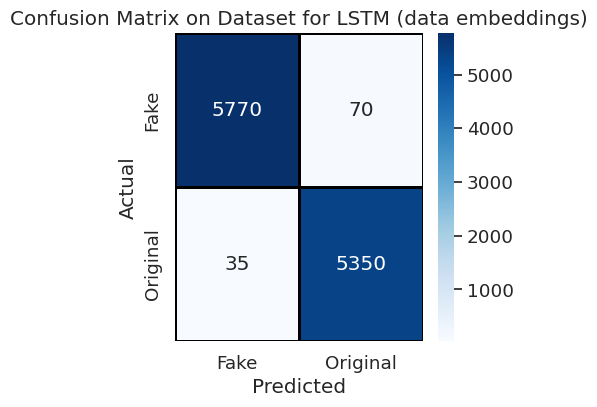

In [ ]:
plt.figure(figsize = (4,4))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix on Dataset for LSTM (data embeddings)")

## Using Pre-Trained Word2Vec Vectors¶

In [ ]:
#invoke garbage collector to free ram
import gc
gc.collect()

5478

In [ ]:
from gensim.models.keyedvectors import KeyedVectors

In [ ]:
# Takes RAM 
word_vectors = KeyedVectors.load_word2vec_format('../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin', binary=True)
EMBEDDING_DIM=300

In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = word_vectors.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)


In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(activation='relu', filters=4, kernel_size=4))
model.add(MaxPool1D())
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_matrix

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=12)

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int")

In [ ]:
accuracy_score(y_test, y_pred)

## Using Glove embeddings

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [ ]:
max_features = 10000
maxlen = 300

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(tokenized_train, maxlen=maxlen)
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
EMBEDDING_FILE = '/content/glove.twitter.27B.100d.txt'
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [ ]:
batch_size = 256
epochs = 10
embed_size = 100

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
132/132 [==============================] - 699s 5s/step - loss: 0.1543 - accuracy: 0.9369 - val_loss: 0.0367 - val_accuracy: 0.9864 - lr: 0.0100
Epoch 2/10
132/132 [==============================] - 730s 6s/step - loss: 0.0214 - accuracy: 0.9936 - val_loss: 0.0168 - val_accuracy: 0.9956 - lr: 0.0100
Epoch 3/10
132/132 [==============================] - 723s 5s/step - loss: 0.0162 - accuracy: 0.9944 - val_loss: 0.0242 - val_accuracy: 0.9943 - lr: 0.0100
Epoch 4/10
132/132 [==============================] - 724s 5s/step - loss: 0.0157 - accuracy: 0.9954 - val_loss: 0.0118 - val_accuracy: 0.9965 - lr: 0.0100
Epoch 5/10
132/132 [==============================] - 723s 5s/step - loss: 0.0188 - accuracy: 0.9945 - val_loss: 0.0143 - val_accuracy: 0.9956 - lr: 0.0100
Epoch 6/10
132/132 [==============================] - 723s 5s/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.0098 - val_accuracy: 0.9976 - lr: 0.0100
Epoch 7/10
132/132 [==============================] - 723s 5s/st

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 183s 174ms/step - loss: 0.0014 - accuracy: 0.9996
Accuracy of the model on Training Data is -  99.9643623828888 %
351/351 [==============================] - 60s 170ms/step - loss: 0.0085 - accuracy: 0.9978
Accuracy of the model on Testing Data is -  99.77728128433228 %


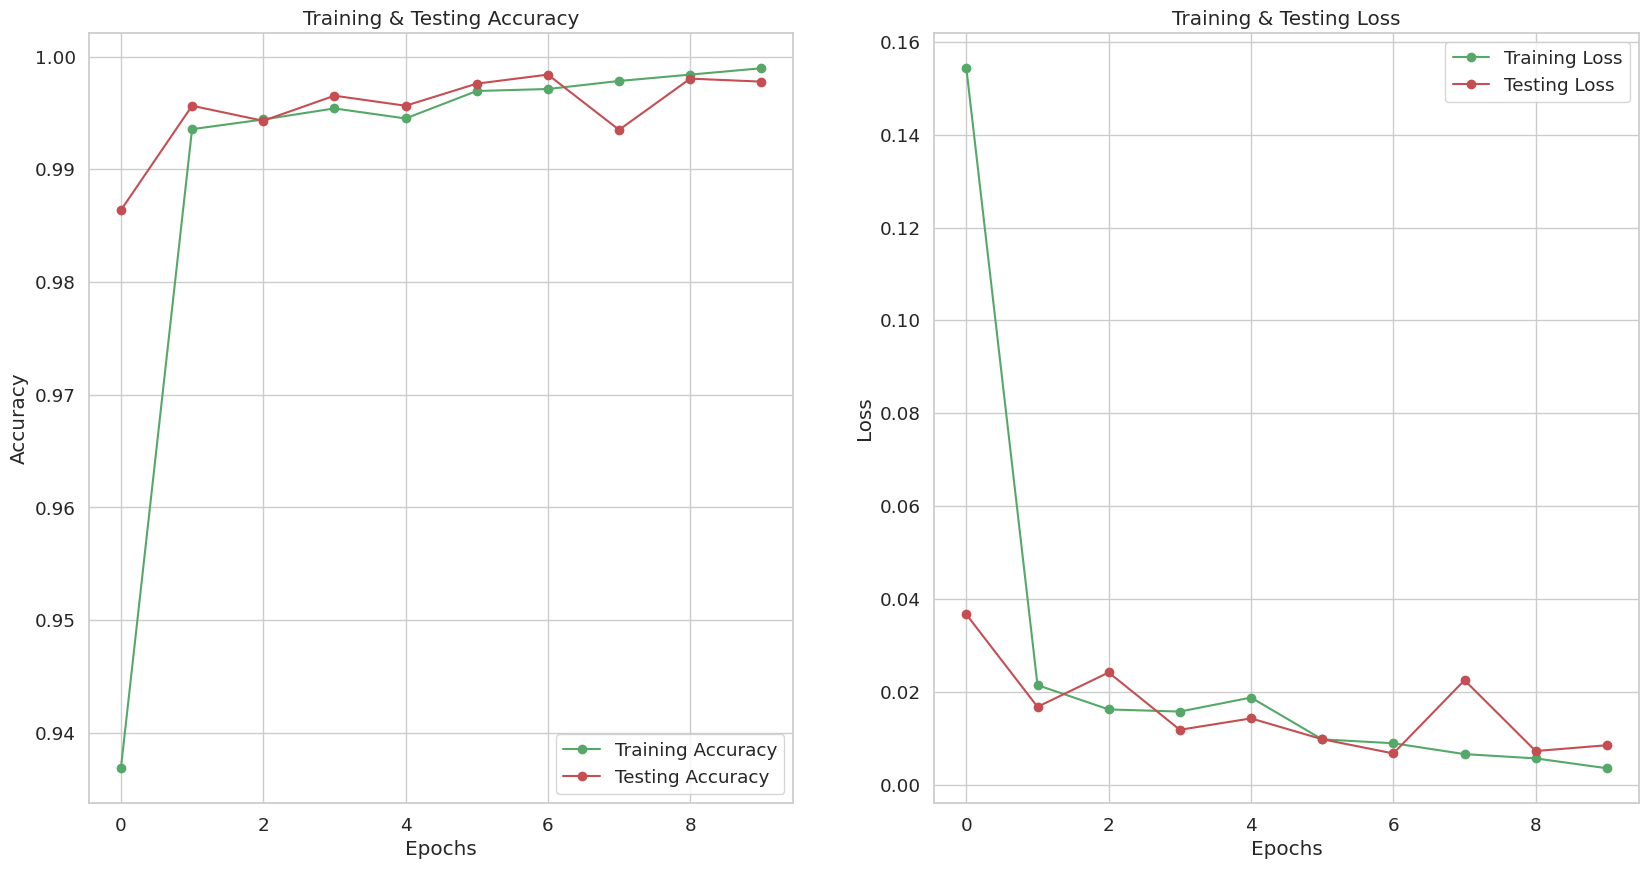

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred = (model.predict(X_test) >= 0.5).astype("int")

351/351 [==============================] - 63s 181ms/step


In [ ]:
pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [ ]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(0.5, 1.0, 'Confusion Matrix on Dataset for LSTM (Glove embeddings)')

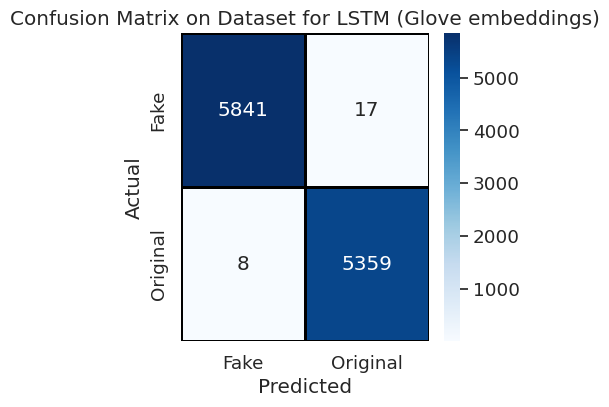

In [ ]:
plt.figure(figsize = (4,4))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix on Dataset for LSTM (Glove embeddings)")